In [102]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")

import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from synthetics import generate_single_task_unipolar, gaussian_bags_of_words, vocab1k

N = 1000
M = 30
K = 2
NUM_SPLITS = 3

Ds = [] # data
Xs = [] # features
Ls = [] # noisy labels
Ys = [] # true labels
for _ in range(NUM_SPLITS):
    L, Y, _ = generate_single_task_unipolar(
        N, M, k=K, alpha_range=[0.6, 0.9], beta_range=[0.1, 0.2], 
        class_balance=[0.3, 0.7], polarity_balance=None, seed=1)
    
    X, D = gaussian_bags_of_words(Y, vocab1k)
    
    Ls.append(L)
    Ys.append(Y)
    Ds.append(D)
    Xs.append(X)

In [69]:
search_space = {
    'n_epochs': 25,
    'l2': [0.0, 0.01, 0.1],
    'lr': {'range': [0.0001, 1], 'scale': 'log'},
}

In [103]:
# First run basic grid search / random search
from metal.label_model import LabelModel
from metal.tuner import ModelTuner

tuner = ModelTuner(LabelModel)
init_args = []
train_args = [Ls[0]]
model, best_config, run_stats_random_search = tuner.search(init_args, train_args, Ls[1], Ys[1], 
                                                           search_space, max_search=100, metric='f1')

[1] Testing {'l2': 0.0, 'lr': 0.013951803159393374}
Computing O...
Estimating \mu...
[Epoch 0] Loss: 52.976555
[Epoch 10] Loss: 11.175468
[Epoch 20] Loss: 0.137310
[Epoch 24] Loss: 0.798052
F1: 0.555
[2] Testing {'l2': 0.01, 'lr': 0.10760132314343232}
Computing O...
Estimating \mu...
[Epoch 0] Loss: 40.082180
[Epoch 10] Loss: 6.869308
[Epoch 20] Loss: 1.661279
[Epoch 24] Loss: 1.614005
F1: 0.249
[3] Testing {'l2': 0.1, 'lr': 0.24532112507341663}
Computing O...
Estimating \mu...
[Epoch 0] Loss: 35.337116
[4] Testing {'l2': 0.0, 'lr': 0.0001683470346495709}
Computing O...
Estimating \mu...
[Epoch 0] Loss: 36.259949
[Epoch 10] Loss: 28.974703
[Epoch 20] Loss: 19.259520
[Epoch 24] Loss: 16.209412
F1: 0.647
[5] Testing {'l2': 0.01, 'lr': 0.015028543792711421}
Computing O...
Estimating \mu...
[Epoch 0] Loss: 57.729797
[Epoch 10] Loss: 12.960503
[Epoch 20] Loss: 0.991340
[Epoch 24] Loss: 1.650515
F1: 0.511
[6] Testing {'l2': 0.1, 'lr': 0.0002586212085889696}
Computing O...
Estimating \mu...
[

In [106]:

# Hyperband
from metal.label_model import LabelModel
from metal.tuner import HyperbandTuner

tuner = HyperbandTuner(LabelModel, hyperband_epochs_budget=5000)
init_args = []
train_args = [Ls[0]]
model, best_config, run_stats_hyperband = tuner.search(init_args, train_args, Ls[1], Ys[1], 
                                                       search_space, metric='f1')

|           Hyperband Schedule          |
Table consists of tuples of (num configs, num_resources_per_config) which specify how many configs to run and for how many epochs. 
Each bracket starts with a list of random configurations which is successively halved according the schedule.
See the Hyperband paper (https://arxiv.org/pdf/1603.06560.pdf) for more details.
-----------------------------------------
Bracket 0: (81, 2) (27, 8) (9, 26) (3, 80) (1, 242)
Bracket 1: (27, 8) (9, 26) (3, 80) (1, 241)
Bracket 2: (9, 26) (3, 80) (1, 241)
Bracket 3: (6, 80) (2, 241)
Bracket 4: (5, 242)
-----------------------------------------
[0 Testing {'l2': 0.0, 'lr': 0.013951803159393374}
Computing O...
Estimating \mu...
[Epoch 0] Loss: 52.976555
[Epoch 1] Loss: 29.394106
F1: 0.611
[1 Testing {'l2': 0.01, 'lr': 0.055903530501292764}
Computing O...
Estimating \mu...
[Epoch 0] Loss: 40.082180
[Epoch 1] Loss: 3.152918
F1: 0.493
[2 Testing {'l2': 0.1, 'lr': 0.0006516952188155327}
Computing O...
Estimating \

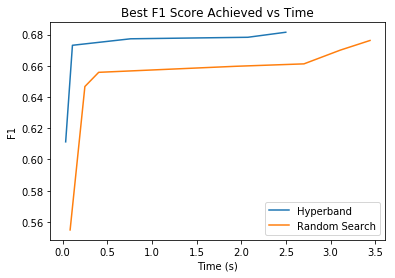

In [ ]:
%matplotlib inline


# Plot random search vs hyperband run stats
import matplotlib.pyplot as plt

xs_hyperband = [x["time_elapsed"] for x in run_stats_hyperband]
ys_hyperband = [x["best_score"] for x in run_stats_hyperband]
xs_rs = [x["time_elapsed"] for x in run_stats_random_search]
ys_rs = [x["best_score"] for x in run_stats_random_search]

plt.plot(xs_hyperband, ys_hyperband, label="Hyperband")
plt.plot(xs_rs, ys_rs, label="Random Search")
plt.legend(loc="best")
plt.title("Best F1 Score Achieved vs Time")
plt.xlabel("Time (s)")
plt.ylabel("F1")